# 0. About

This notebook is to test out the linear CCA with various packages.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import warnings

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import CCA, PLSCanonical
from sklearn.utils import Bunch
from sklearn.metrics.pairwise import cosine_similarity

from cca_zoo.models import CCA as cz_CCA
from cca_zoo.models import rCCA as cz_rCCA
from cca_zoo.model_selection import GridSearchCV as cz_GridSearchCV

rs_num = 14
rng = np.random.default_rng(rs_num)

n_splits = 5
n_repeats = 50

sklearn.set_config(display="diagram")

%matplotlib inline

# 1. Dataset Construction

In [2]:
def linear_sample_generate(rng, sample_num, X_dim, Y_dim):
    # construct X
    X = np.zeros((sample_num, X_dim))
    for x_i in range(X_dim):
        X[:, x_i] = rng.normal(loc=0.0, scale=1.0, size=(sample_num, ))
    
    # construct noise
    xi_1 = rng.normal(loc=0, scale=0.2, size=(sample_num, ))
    xi_2 = rng.normal(loc=0, scale=0.4, size=(sample_num, ))
    xi_3 = rng.normal(loc=0, scale=0.3, size=(sample_num, ))
    
    # construct Y
    Y = np.zeros((sample_num, Y_dim))
    Y[:, 0] = X[:, 2] + xi_1
    Y[:, 1] = X[:, 0] + xi_2
    Y[:, 2] = -X[:, 3] + xi_3
    for y_i in range(3, Y_dim):
        Y[:, y_i] = rng.normal(loc=0.0, scale=1.0, size=(sample_num, ))
        
    return [X, Y]

In [3]:
sample_num = 76
X_dimension_num = 4
Y_dimension_num = 3

[X, Y] = linear_sample_generate(
    rng, sample_num, X_dimension_num, Y_dimension_num
)

We can also check out the correlation between X and Y:

In [4]:
data_df = pd.DataFrame(
    data=np.concatenate([X, Y], axis=1), 
    columns=(
        ['x{}'.format(i+1) for i in range(X_dimension_num)] + 
        ['y{}'.format(i+1) for i in range(Y_dimension_num)]
    )
)

corr_cmap = sns.color_palette('vlag', as_cmap=True)

display(
    data_df.corr(
        method='pearson'
    ).style.background_gradient(cmap=corr_cmap).format(precision=2)
)

,x1,x2,x3,x4,y1,y2,y3
x1,1.00,0.04,0.06,0.11,0.08,0.92,-0.07
x2,0.04,1.00,0.08,-0.05,0.10,-0.00,0.07
x3,0.06,0.08,1.00,-0.16,0.99,0.06,0.05
x4,0.11,-0.05,-0.16,1.00,-0.14,-0.01,-0.95
y1,0.08,0.10,0.99,-0.14,1.00,0.07,0.04
y2,0.92,-0.00,0.06,-0.01,0.07,1.00,0.04
y3,-0.07,0.07,0.05,-0.95,0.04,0.04,1.00


Split the dataset into training and testing datasets:

In [5]:
[X_train, X_test, Y_train, Y_test] = train_test_split(
    X, Y, test_size=0.20, random_state=rs_num
)

Standardize two matrices:

In [6]:
# standardization of two matrices
X_train_scaler = StandardScaler().fit(X_train)
X_train_standardized = X_train_scaler.transform(X_train)
X_test_standardized = X_train_scaler.transform(X_test)

Y_train_scaler = StandardScaler().fit(Y_train)
Y_train_standardized = Y_train_scaler.transform(Y_train)
Y_test_standardized = Y_train_scaler.transform(Y_test)

We can also get a baseline model evaluation through linear regression.

In [7]:
baseline_bunch = Bunch()
baseline_bunch.name = 'baseline'

baseline_bunch.pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), 
        ('lr', LinearRegression())
    ]
)

baseline_bunch.cv_scores = cross_validate(
    baseline_bunch.pipeline, X_train, Y_train, 
    cv=RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
)['test_score']

# also train on the whole training dataset, and see the score on the test dataset
baseline_bunch.pipeline.fit(X_train, Y_train)

# modal evaluation on the test dataset
baseline_bunch.eval_score = baseline_bunch.pipeline.score(X_test, Y_test)

# 2. CCA via sklearn CCA

In [8]:
# create a customized cross-validation method
def custom_cv(validator, X, Y, fit_n_score_func, *args):
    # note: normally X and Y are already training datasets
    
    # construct score array
    score_arr = np.zeros((validator.get_n_splits(), ))
    
    # fit and validate
    ii = 0
    for train_ind, test_ind in validator.split(X):
        # slicing arrays
        X_train, X_test = X[train_ind], X[test_ind]
        Y_train, Y_test = Y[train_ind], Y[test_ind]
        
        # train the model and get the score
        score_arr[ii] = fit_n_score_func(X_train, X_test, Y_train, Y_test, *args)
        ii += 1
    
    return score_arr

In [9]:
# create a customized pipeline
def sklearn_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components, max_iter, tol):
    # fitting the model
    cca = CCA(n_components=n_components, max_iter=max_iter, tol=tol).fit(X_train, Y_train)
    
    # transform the model
    Xc_train, Yc_train = cca.transform(X_train, Y_train)
    Xc_test, Yc_test = cca.transform(X_test, Y_test)
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [10]:
sklearn_bunch = Bunch()
sklearn_bunch.name = 'sklearn'

sklearn_bunch.rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
sklearn_bunch.n_components = np.min([X_dimension_num, Y_dimension_num])
sklearn_bunch.max_iter = int(1e12)
sklearn_bunch.tol = 1e-12

In [11]:
# manuallly chain them together
sklearn_bunch.cca = CCA(
    n_components=sklearn_bunch.n_components, 
    max_iter=sklearn_bunch.max_iter, 
    tol=sklearn_bunch.tol
).fit(X_train, Y_train)

# note: X and Y will be standardized
[sklearn_bunch.Xc_train, 
 sklearn_bunch.Yc_train] = sklearn_bunch.cca.transform(X_train, Y_train)
[sklearn_bunch.Xc_test, 
 sklearn_bunch.Yc_test] = sklearn_bunch.cca.transform(X_test, Y_test)

# calculate canonical correlation
sklearn_bunch.cc = np.corrcoef(
    sklearn_bunch.Xc_train.T, sklearn_bunch.Yc_train.T
).diagonal(offset=sklearn_bunch.n_components)

# also compare if pre-standardization would make a difference
[sklearn_bunch.check_Xc_train, 
 sklearn_bunch.check_Yc_train] = CCA(
    n_components=sklearn_bunch.n_components, 
    max_iter=sklearn_bunch.max_iter, 
    tol=sklearn_bunch.tol
).fit_transform(X_train_standardized, Y_train_standardized)

print(
    'Pre-standardization makes {:.2e} total difference on X'.format(
        np.linalg.norm(
            sklearn_bunch.check_Xc_train - sklearn_bunch.Xc_train
        )
    )
)
print(
    'Pre-standardization makes {:.2e} total difference on Y'.format(
        np.linalg.norm(
            sklearn_bunch.check_Yc_train - sklearn_bunch.Yc_train
        )
    )
)

Pre-standardization makes 1.49e-13 total difference on X
Pre-standardization makes 1.55e-13 total difference on Y


We can also see how the correlation in the transformed matrices:

In [12]:
sklearn_bunch.data_df = pd.DataFrame(
    data=np.concatenate(
        [sklearn_bunch.Xc_train, sklearn_bunch.Yc_train], axis=1
    ), 
    columns=(
        ['xc{}'.format(i+1) for i in range(sklearn_bunch.Xc_train.shape[1])] + 
        ['yc{}'.format(i+1) for i in range(sklearn_bunch.Yc_train.shape[1])]
    )
)

display(sklearn_bunch.data_df.corr(
    method='pearson'
).style.background_gradient(cmap=corr_cmap).format(precision=2))

,xc1,xc2,xc3,yc1,yc2,yc3
xc1,1.00,-0.00,0.00,0.99,0.00,-0.00
xc2,-0.00,1.00,0.00,-0.00,0.95,0.00
xc3,0.00,0.00,1.00,0.00,0.00,0.94
yc1,0.99,-0.00,0.00,1.00,-0.00,0.00
yc2,0.00,0.95,0.00,-0.00,1.00,-0.00
yc3,-0.00,0.00,0.94,0.00,-0.00,1.00


Now we can similarly apply the same Linear Regression on the transformed datasets.

In [13]:
sklearn_bunch.cv_scores = custom_cv(
    sklearn_bunch.rkf, X_train, Y_train, 
    sklearn_cca_fit_n_score, 
    sklearn_bunch.n_components, 
    sklearn_bunch.max_iter, 
    sklearn_bunch.tol
)

# also evaluate them manually
sklearn_bunch.eval_score = sklearn_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    sklearn_bunch.n_components, sklearn_bunch.max_iter, sklearn_bunch.tol
)

# 3. CCA via Standard Eigenvalue Problem

In [14]:
# compute joint covariance matrix
C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

Cxx = C[0:X_dimension_num, 0:X_dimension_num]
Cxy = C[0:X_dimension_num, X_dimension_num:]
Cyy = C[X_dimension_num:, X_dimension_num:]

C_compute = np.linalg.multi_dot(
    [np.linalg.inv(Cyy), Cxy.T, np.linalg.inv(Cxx), Cxy]
)


In [15]:
# standard eigenvalue problem
std_eig_bunch = Bunch()
std_eig_bunch.name = 'std eig'

# solve eig
[std_eig_bunch.eig_val, 
 std_eig_bunch.eig_vec] = np.linalg.eig(C_compute)

# Y matrix weights
std_eig_bunch.wy = std_eig_bunch.eig_vec

std_eig_bunch.cc_arr = np.sqrt(std_eig_bunch.eig_val)
print('The canonical correlation is:')
print(std_eig_bunch.cc_arr)

# X matrix weights
std_eig_bunch.wx = np.linalg.multi_dot(
    [np.linalg.inv(Cxx), Cxy, std_eig_bunch.wy]
)/std_eig_bunch.cc_arr

The canonical correlation is:
[0.9871237  0.94172067 0.94754613]


In [16]:
# sort by canonical correlation
sort_ind = std_eig_bunch.cc_arr.argsort()
std_eig_bunch.cc_arr_sorted = std_eig_bunch.cc_arr[sort_ind[::-1]]
std_eig_bunch.wx_sorted = std_eig_bunch.wx[:, sort_ind[::-1]]
std_eig_bunch.wy_sorted = std_eig_bunch.wy[:, sort_ind[::-1]]

del sort_ind

In [17]:
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(sklearn_bunch.cc)

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.9871237  0.94754613 0.94172067]

Canonical Correlation calculated by sklearn CCA:
[0.9871237  0.94754613 0.94172067]


In [18]:
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(sklearn_bunch.cca.x_rotations_)

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[ 0.17738047 -0.08125182 -0.95529448]
 [ 0.03694785 -0.01147978 -0.01088881]
 [ 0.97490875 -0.2274832   0.31498427]
 [-0.06362378 -1.00221576  0.16789861]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.17850928  0.07987844  0.9529788 ]
 [ 0.0371842   0.0112956   0.01086342]
 [ 0.9811487   0.22387451 -0.31419529]
 [-0.06402339  0.98624452 -0.16741427]]


In [19]:
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(sklearn_bunch.cca.y_rotations_)

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[ 0.98662565 -0.09112597  0.28551694]
 [ 0.15338246 -0.11535419 -0.9543848 ]
 [ 0.05516926  0.98913572 -0.08734837]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98662688  0.09127201 -0.28797009]
 [ 0.15337692  0.11543874  0.96263648]
 [ 0.05516274 -0.99053756  0.08802721]]


We can see how close of those weights:

In [20]:
def cos_sim_two_weights(weights_1, weights_2):
    for w_i in range(weights_1.shape[1]):
        w_i_cos_sim = cosine_similarity(
            weights_1[:, w_i].reshape(1, -1), 
            weights_2[:, w_i].reshape(1, -1)
        )[0][0]
        print(w_i_cos_sim)

In [21]:
print('w_x comparison between sklearn CCA and CCA through solving standard eigenvalue problem:')
cos_sim_two_weights(
    sklearn_bunch.cca.x_rotations_, std_eig_bunch.wx_sorted
)

w_x comparison between sklearn CCA and CCA through solving standard eigenvalue problem:
0.9999999999510236
-0.9999999968731359
-0.9999999970019144


In [22]:
print('w_y comparison between sklearn CCA and CCA through solving standard eigenvalue problem:')
cos_sim_two_weights(
    sklearn_bunch.cca.y_rotations_, std_eig_bunch.wy_sorted
)

w_y comparison between sklearn CCA and CCA through solving standard eigenvalue problem:
0.9999999999626589
-0.9999999967797645
-0.9999999970751217


They are pretty close to each other.

Now we can see how well this method handles the datasets.

In [23]:
# create a customized pipeline
def std_eig_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]

    C_compute = np.linalg.multi_dot(
        [np.linalg.inv(Cyy), Cxy.T, np.linalg.inv(Cxx), Cxy]
    )
    
    # solve standard eigenvalue problem
    [eig_val, eig_vec] = np.linalg.eig(C_compute)
    
    # canonical correlation values
    cc_arr = np.sqrt(eig_val)

    # matrices weights
    wy = eig_vec
    wx = np.linalg.multi_dot([np.linalg.inv(Cxx), Cxy, wy])/cc_arr
    
    # sort by canonical correlation
    cc_argind = cc_arr.argsort()
    cc_arr_sorted = cc_arr[cc_argind[::-1]]
    wx_sorted = wx[:, cc_argind[::-1]]
    wy_sorted = wy[:, cc_argind[::-1]]
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [24]:
std_eig_bunch.rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
std_eig_bunch.n_components = sklearn_bunch.n_components

In [25]:
# cross-validate
std_eig_bunch.cv_scores = custom_cv(
    std_eig_bunch.rkf, X_train, Y_train, 
    std_eig_cca_fit_n_score, 
    std_eig_bunch.n_components
)

# also evaluate them manually
std_eig_bunch.eval_score = std_eig_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    std_eig_bunch.n_components
)

# 4. CCA via Generalized Eigenvalue Problem

In [26]:
gen_eig_bunch = Bunch()
gen_eig_bunch.name = 'gen eig'

In [27]:
# construct general matrices
gen_eig_bunch.A = np.zeros(
    (
        X_dimension_num+Y_dimension_num, 
        X_dimension_num+Y_dimension_num
    )
)
gen_eig_bunch.A[:X_dimension_num, X_dimension_num:] = Cxy
gen_eig_bunch.A[X_dimension_num:, :X_dimension_num] = Cxy.T

gen_eig_bunch.B = np.zeros_like(gen_eig_bunch.A)
gen_eig_bunch.B[:X_dimension_num, :X_dimension_num] = Cxx
gen_eig_bunch.B[X_dimension_num:, X_dimension_num:] = Cyy

# solve generalized eigenvalue problem
[gen_eig_bunch.eig_val, 
 gen_eig_bunch.eig_vec] = scipy.linalg.eigh(gen_eig_bunch.A, gen_eig_bunch.B)

# retrive canonical correlation and weight vectors
gen_eig_bunch.cc_arr = gen_eig_bunch.eig_val[gen_eig_bunch.eig_val>=1e-6]
gen_eig_bunch.eig_vec_positive = gen_eig_bunch.eig_vec[:, gen_eig_bunch.eig_val>=1e-6]

# sort out w.r.t. cc values
sort_ind = gen_eig_bunch.cc_arr.argsort()
gen_eig_bunch.cc_arr_sorted = gen_eig_bunch.cc_arr[sort_ind[::-1]]
gen_eig_bunch.eig_vec_positive_sorted = gen_eig_bunch.eig_vec_positive[:, sort_ind[::-1]]
gen_eig_bunch.wx_sorted = gen_eig_bunch.eig_vec_positive_sorted[:X_dimension_num, :]
gen_eig_bunch.wy_sorted = gen_eig_bunch.eig_vec_positive_sorted[X_dimension_num:, :]

del sort_ind

Check out results v.s. other methods

In [28]:
print('Canonical Correlation calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(sklearn_bunch.cc)

Canonical Correlation calculated by Generalized Eigenvalue Problem:
[0.9871237  0.94754613 0.94172067]

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.9871237  0.94754613 0.94172067]

Canonical Correlation calculated by sklearn CCA:
[0.9871237  0.94754613 0.94172067]


In [29]:
print('Weight vector w_x calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(sklearn_bunch.cca.x_rotations_)

Weight vector w_x calculated by Generalized Eigenvalue Problem:
[[ 0.12242169  0.05790795 -0.70202132]
 [ 0.02550009  0.00818161 -0.00800191]
 [ 0.67284731  0.16212664  0.23147383]
 [-0.04391087  0.71427638  0.12338436]]

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[ 0.17738047 -0.08125182 -0.95529448]
 [ 0.03694785 -0.01147978 -0.01088881]
 [ 0.97490875 -0.2274832   0.31498427]
 [-0.06362378 -1.00221576  0.16789861]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.17850928  0.07987844  0.9529788 ]
 [ 0.0371842   0.0112956   0.01086342]
 [ 0.9811487   0.22387451 -0.31419529]
 [-0.06402339  0.98624452 -0.16741427]]


In [30]:
print('Weight vector w_y calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(sklearn_bunch.cca.y_rotations_)

Weight vector w_y calculated by Generalized Eigenvalue Problem:
[[ 0.6809339   0.06494523  0.20981905]
 [ 0.10585911  0.08221261 -0.70135282]
 [ 0.03807586 -0.70495426 -0.06419007]]

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[ 0.98662565 -0.09112597  0.28551694]
 [ 0.15338246 -0.11535419 -0.9543848 ]
 [ 0.05516926  0.98913572 -0.08734837]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98662688  0.09127201 -0.28797009]
 [ 0.15337692  0.11543874  0.96263648]
 [ 0.05516274 -0.99053756  0.08802721]]


We can see how close of those weights:

In [31]:
print('w_x comparison between sklearn CCA and CCA through solving generalized eigenvalue problem:')
cos_sim_two_weights(
    sklearn_bunch.cca.x_rotations_, gen_eig_bunch.wx_sorted
)

w_x comparison between sklearn CCA and CCA through solving generalized eigenvalue problem:
0.9999999999510236
0.9999999968731358
-0.9999999970019144


In [32]:
print('w_y comparison between sklearn CCA and CCA through solving generalized eigenvalue problem:')
cos_sim_two_weights(
    sklearn_bunch.cca.y_rotations_, gen_eig_bunch.wy_sorted
)

w_y comparison between sklearn CCA and CCA through solving generalized eigenvalue problem:
0.999999999962659
0.9999999967797643
-0.9999999970751217


They are pretty close to each other.

Now we can evaluate the model.

In [33]:
def gen_eig_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    Y_dimension_num = Y_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]
    
    # construct general matrices
    A = np.zeros(
        (
            X_dimension_num+Y_dimension_num, 
            X_dimension_num+Y_dimension_num
        )
    )
    A[:X_dimension_num, X_dimension_num:] = Cxy
    A[X_dimension_num:, :X_dimension_num] = Cxy.T

    B = np.zeros_like(A)
    B[:X_dimension_num, :X_dimension_num] = Cxx
    B[X_dimension_num:, X_dimension_num:] = Cyy
    
    # solve generalized eigenvalue problem
    [eig_val, eig_vec] = scipy.linalg.eigh(A, B)

    # retrive canonical correlation and weight vectors
    cc_arr = eig_val[eig_val>=1e-6]
    eig_vec_positive = eig_vec[:, eig_val>=1e-6]
    
    # sort out w.r.t. cc values
    sort_ind = cc_arr.argsort()
    cc_arr_sorted = cc_arr[sort_ind[::-1]]
    eig_vec_positive_sorted = eig_vec_positive[:, sort_ind[::-1]]
    wx_sorted = eig_vec_positive_sorted[:X_dimension_num, :]
    wy_sorted = eig_vec_positive_sorted[X_dimension_num:, :]
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [34]:
gen_eig_bunch.rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
gen_eig_bunch.n_components = sklearn_bunch.n_components

In [35]:
# cross-validate
gen_eig_bunch.cv_scores = custom_cv(
    gen_eig_bunch.rkf, X_train, Y_train, 
    gen_eig_cca_fit_n_score, 
    gen_eig_bunch.n_components
)

# also evaluate them manually
gen_eig_bunch.eval_score = gen_eig_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    gen_eig_bunch.n_components
)

# 5. CCA via SVD

In [36]:
svd_bunch = Bunch()
svd_bunch.name = 'svd'

In [37]:
svd_bunch.Cxx_sqrt_inv = scipy.linalg.inv(
    scipy.linalg.sqrtm(Cxx)
) 
svd_bunch.Cyy_sqrt_inv = scipy.linalg.inv(
    scipy.linalg.sqrtm(Cyy)
)
svd_bunch.mat_to_svd = np.linalg.multi_dot(
    [svd_bunch.Cxx_sqrt_inv, Cxy, svd_bunch.Cyy_sqrt_inv]
) # matrix to SVD

# SVD decomposition
[svd_bunch.U, 
 svd_bunch.cc_arr_sorted, 
 svd_bunch.Vh] = scipy.linalg.svd(
    svd_bunch.mat_to_svd, full_matrices=False
)

# compute weights vectors
svd_bunch.wx_sorted = np.matmul(svd_bunch.Cxx_sqrt_inv, svd_bunch.U)
svd_bunch.wy_sorted = np.matmul(svd_bunch.Cyy_sqrt_inv, svd_bunch.Vh.T)

We can compare the Canonical Correlation and Weights with other methods.

In [38]:
print('Canonical Correlation calculated by SVD:')
print(svd_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.cc_arr_sorted)
print('')
print('Canonical Correlation calculated by sklearn CCA:')
print(sklearn_bunch.cc)

Canonical Correlation calculated by SVD:
[0.9871237  0.94754613 0.94172067]

Canonical Correlation calculated by Generalized Eigenvalue Problem:
[0.9871237  0.94754613 0.94172067]

Canonical Correlation calculated by Standard Eigenvalue Problem:
[0.9871237  0.94754613 0.94172067]

Canonical Correlation calculated by sklearn CCA:
[0.9871237  0.94754613 0.94172067]


In [39]:
print('Weight vector w_x calculated by SVD:')
print(svd_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wx_sorted)
print('')
print('Weight vector w_x calculated by sklearn CCA:')
print(sklearn_bunch.cca.x_rotations_)

Weight vector w_x calculated by SVD:
[[-0.17313041  0.0818942   0.99280807]
 [-0.03606257  0.01157054  0.0113164 ]
 [-0.95154979  0.2292817  -0.32735343]
 [ 0.06209935  1.01013934 -0.17449184]]

Weight vector w_x calculated by Generalized Eigenvalue Problem:
[[ 0.12242169  0.05790795 -0.70202132]
 [ 0.02550009  0.00818161 -0.00800191]
 [ 0.67284731  0.16212664  0.23147383]
 [-0.04391087  0.71427638  0.12338436]]

Weight vector w_x calculated by Standard Eigenvalue Problem:
[[ 0.17738047 -0.08125182 -0.95529448]
 [ 0.03694785 -0.01147978 -0.01088881]
 [ 0.97490875 -0.2274832   0.31498427]
 [-0.06362378 -1.00221576  0.16789861]]

Weight vector w_x calculated by sklearn CCA:
[[ 0.17850928  0.07987844  0.9529788 ]
 [ 0.0371842   0.0112956   0.01086342]
 [ 0.9811487   0.22387451 -0.31419529]
 [-0.06402339  0.98624452 -0.16741427]]


In [40]:
print('Weight vector w_y calculated by SVD:')
print(svd_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by Generalized Eigenvalue Problem:')
print(gen_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by Standard Eigenvalue Problem:')
print(std_eig_bunch.wy_sorted)
print('')
print('Weight vector w_y calculated by sklearn CCA:')
print(sklearn_bunch.cca.y_rotations_)

Weight vector w_y calculated by SVD:
[[-0.96298595  0.09184642 -0.29672894]
 [-0.14970739  0.11626619  0.99186266]
 [-0.05384739 -0.99695588  0.09077847]]

Weight vector w_y calculated by Generalized Eigenvalue Problem:
[[ 0.6809339   0.06494523  0.20981905]
 [ 0.10585911  0.08221261 -0.70135282]
 [ 0.03807586 -0.70495426 -0.06419007]]

Weight vector w_y calculated by Standard Eigenvalue Problem:
[[ 0.98662565 -0.09112597  0.28551694]
 [ 0.15338246 -0.11535419 -0.9543848 ]
 [ 0.05516926  0.98913572 -0.08734837]]

Weight vector w_y calculated by sklearn CCA:
[[ 0.98662688  0.09127201 -0.28797009]
 [ 0.15337692  0.11543874  0.96263648]
 [ 0.05516274 -0.99053756  0.08802721]]


We can see how close of those weights:

In [41]:
print('w_x comparison between sklearn CCA and CCA through solving SVD:')
cos_sim_two_weights(
    sklearn_bunch.cca.x_rotations_, svd_bunch.wx_sorted
)

w_x comparison between sklearn CCA and CCA through solving SVD:
-0.9999999999510237
0.9999999968731359
0.9999999970019144


In [42]:
print('w_y comparison between sklearn CCA and CCA through solving SVD:')
cos_sim_two_weights(
    sklearn_bunch.cca.y_rotations_, svd_bunch.wy_sorted
)

w_y comparison between sklearn CCA and CCA through solving SVD:
-0.999999999962659
0.9999999967797644
0.9999999970751217


We can check out the differences for the weights by calculating the cosine similarities:

In [43]:
def svd_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components):
    X_dimension_num = X_train.shape[1]
    Y_dimension_num = Y_train.shape[1]
    
    # standardization of two matrices
    X_train_scaler = StandardScaler().fit(X_train)
    X_train_standardized = X_train_scaler.transform(X_train)
    X_test_standardized = X_train_scaler.transform(X_test)

    Y_train_scaler = StandardScaler().fit(Y_train)
    Y_train_standardized = Y_train_scaler.transform(Y_train)
    Y_test_standardized = Y_train_scaler.transform(Y_test)
    
    # compute joint covariance matrix
    C = np.cov(X_train_standardized.T, Y_train_standardized.T, ddof=0)

    Cxx = C[0:X_dimension_num, 0:X_dimension_num]
    Cxy = C[0:X_dimension_num, X_dimension_num:]
    Cyy = C[X_dimension_num:, X_dimension_num:]
    
    
    Cxx_sqrt_inv = scipy.linalg.inv(
        scipy.linalg.sqrtm(Cxx)
    )
    Cyy_sqrt_inv = scipy.linalg.inv(
        scipy.linalg.sqrtm(Cyy)
    )
    mat_to_svd = np.linalg.multi_dot(
        [Cxx_sqrt_inv, Cxy, Cyy_sqrt_inv]
    ) # matrix to SVD

    # SVD decomposition
    [U, cc_arr_sorted, Vh] = scipy.linalg.svd(
        mat_to_svd, full_matrices=False
    )

    # compute weights vectors
    wx_sorted = np.matmul(Cxx_sqrt_inv, U)
    wy_sorted = np.matmul(Cyy_sqrt_inv, Vh.T)
    
    # transform matrices
    Xc_train = X_train_standardized.dot(wx_sorted)[:, :n_components]
    Xc_test = X_test_standardized.dot(wx_sorted)[:, :n_components]
    Yc_train = Y_train_standardized.dot(wy_sorted)[:, :n_components]
    Yc_test = Y_test_standardized.dot(wy_sorted)[:, :n_components]
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [44]:
svd_bunch.rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)
svd_bunch.n_components = sklearn_bunch.n_components

In [45]:
# cross-validate
svd_bunch.cv_scores = custom_cv(
    svd_bunch.rkf, X_train, Y_train, 
    svd_cca_fit_n_score, 
    svd_bunch.n_components
)

# also evaluate them manually
svd_bunch.eval_score = svd_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    svd_bunch.n_components
)

In [46]:
# visualization method
def viz_bunch_list(ax, bunch_list):
    # visualize model evaluation
    viz_labels = []
    viz_boxplots = []
    viz_eval_scores = []
    viz_eval_scores_pos = []

    for i, bunch in enumerate(bunch_list):
        viz_labels.append(bunch.name)
        viz_boxplots.append(bunch.cv_scores)
        viz_eval_scores.append(bunch.eval_score)
        viz_eval_scores_pos.append(i+1)
    
    ax.boxplot(
        viz_boxplots, 
        labels=viz_labels
    )
    ax.scatter(
        viz_eval_scores_pos, 
        viz_eval_scores, 
        fc='none',
        ec='blue', 
        marker='^', 
        label='scores on test dataset'
    )
    
    ax.set_xticklabels(viz_labels, rotation=45)
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, -0.22),
        fancybox=True,
        shadow=True,
        ncol=1,
        fontsize='small'
    )

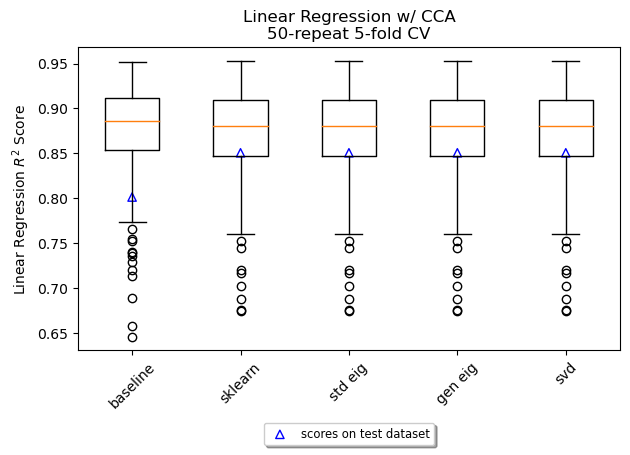

In [47]:
# put everything in one list
bunch_list = [
    baseline_bunch, 
    sklearn_bunch, 
    std_eig_bunch, 
    gen_eig_bunch, 
    svd_bunch
]

# visualization
fig, ax = plt.subplots()

viz_bunch_list(ax, bunch_list)

ax.set(
    ylabel='Linear Regression $R^2$ Score', 
    title=(
        'Linear Regression w/ CCA\n' + 
        '{}-repeat {}-fold CV'.format(n_repeats, n_splits)
    )
)

fig.tight_layout()

The performances are pretty the same.

# 6. CCA via CCA Zoo

In [48]:
# create a customized pipeline
def cz_cca_fit_n_score(X_train, X_test, Y_train, Y_test, n_components, rs_num):
    # fitting the model
    cca = cz_CCA(latent_dims=n_components, random_state=rs_num).fit((X_train, Y_train))
    
    # transform the model
    Xc_train, Yc_train = cca.transform((X_train, Y_train))
    Xc_test, Yc_test = cca.transform((X_test, Y_test))
    
    # train with linear regression and get a score
    return LinearRegression().fit(Xc_train, Yc_train).score(Xc_test, Yc_test)

In [49]:
cz_bunch = Bunch()
cz_bunch.name = 'cca-zoo'
cz_bunch.n_components = sklearn_bunch.n_components
cz_bunch.rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=rs_num)

In [50]:
# cross-validate
cz_bunch.cv_scores = custom_cv(
    cz_bunch.rkf, X_train, Y_train, 
    cz_cca_fit_n_score, 
    cz_bunch.n_components, rs_num
)

# also evaluate them manually
cz_bunch.eval_score = cz_cca_fit_n_score(
    X_train, X_test, Y_train, Y_test, 
    cz_bunch.n_components, rs_num
)

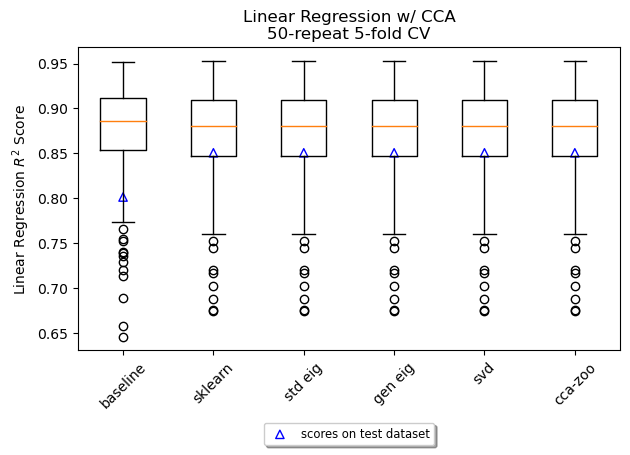

In [51]:
# put everything in one list
bunch_list = [
    baseline_bunch, 
    sklearn_bunch, 
    std_eig_bunch, 
    gen_eig_bunch, 
    svd_bunch, 
    cz_bunch
]

# visualization
fig, ax = plt.subplots()

viz_bunch_list(ax, bunch_list)

ax.set(
    ylabel='Linear Regression $R^2$ Score', 
    title=(
        'Linear Regression w/ CCA\n' + 
        '{}-repeat {}-fold CV'.format(n_repeats, n_splits)
    )
)

fig.tight_layout()